# Detect and Analyze Performance Bottlenecks

This notebook walks you through how SageMaker Debugger detects performance bottlenecks and performs a root cause analysis for a SageMaker training job.

## Specify the training job name and the region name
To start with this notebook, you need to specify the exact name of a training job you want to analyze.

In [ ]:
training_job_name = 'smprofiler-gpu-2020-08-06-07-09-31-626' # specify your training job name
region = 'us-east-1'

### Read profiler data: system metrics and framework metrics

Once the training job is running SageMaker will collect system and framework metrics. The following code cell is waiting for the system metrics & framework metrics to become available in S3. Once they are available you will be able to query and plot those metrics.

In [ ]:
import pandas as pd
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

# 2. Convert data into Pandas frame

## 2.1 Pandas frame for system metrics
 
Smdebug provides a class `PandasFrame` that converts profiler data into Pandas frames. 

In [ ]:
from smdebug.profiler.analysis.utils.profiler_data_to_pandas import PandasFrame

pf = PandasFrame(tj.profiler_s3_output_path)

Following function retrieves all system metrics:

In [ ]:
system_metrics_df = pf.get_all_system_metrics()

Let's have a look on the Pandas frame for system metrics. It has the following entries:
- **timestamp:** when system metrics has been recorded. The timestamp is a datetime object.
- **timestamp_us:** when system metrics has been recorded. The timestamp is normalized by first timestamp. So first entry starts with 0.
- **value:** utilization in percent
- **system_metric:** name of the metric

In [6]:
system_metrics_df.head()

,timestamp,timestamp_us,value,system_metric
0,2020-08-06T07:12:35:624000,35624000,0.0,gpu3
1,2020-08-06T07:12:35:624000,35624000,0.0,gpu0
2,2020-08-06T07:12:35:624000,35624000,0.0,gpu1
3,2020-08-06T07:12:35:624000,35624000,0.0,gpu1
4,2020-08-06T07:12:35:624000,35624000,0.0,gpu2


Next we call `get_all_framework_metrics` that will return a dataframe for framework metrics. There are different metrics such as step duration, dataloading, preprocessing etc. The metrics typically correspond to certain function calls inside the DL framework. Depending on your training job there can be a singificant amount of framework metrics so it is recommended to not load all at once. Therefore the function `get_all_framework_metrics` takes a list of metrics to select. Here, we only select train step information:

In [ ]:
framework_metrics_df = pf.get_all_framework_metrics(selected_framework_metrics=['Step:ModeKeys.TRAIN', 'Step:ModeKeys.GLOBAL'])

Let's have a look on the dataframe. It has the following entries:
- **start_time:** when the function call/event started. The timestamp is a datetime object.
- **end_time:** when the function call/event ended. The timestamp is a datetime object.
- **start_time_us:** when the function call/event started. The timestamp is in microseconds and normalized with the first timestamp in system metrics. This column can be used to merge framework and system metrics frame.
- **end_time_us:** when the function call/event ended. The timestamp is in microseconds and normalized with the first timestamp in system metrics. This column can be used to merge framework and system metrics frame.
- **tid:** ID of the thread that executed this function. This information can be used to analyze how many dataloading threads were running in parallel.
- **pid:** ID of the process that executed this function. This information can be used to analyze how many dataloading threads were running in parallel.
- **framework_metric:** function name/event name
- **step:** step number when this event happened (only for steps)
- **bytes:** how many bytes the function loaded (only for function that do data preprocessing)
- **process:** group of functions 
    

In [ ]:
framework_metrics_df.head()

# 3. Simple Analysis

## 3.1 Training job duration

First we get some statistics about the training job itself. The function `get_job_statistics()` shows when the training job started and finished and how long the initialization, training loop and finalization took. Initialization is the time from the first system metric event (after instance has been created) to the first training step 0. 
During initialization and finalization, GPU will likely be at 0 percent utilization so we want to keep those times as small as possible.

There can be many reasons for long initialization time e.g.: 
- if your training job has to pull large amounts of data from Amazon S3 and you are not using pipe mode, you may see a large intialization time
- in case of multi GPU training we have observed that the time needed for model.compile() in Tensorflow linearly increased the more GPUs were used in the training

Finalization is the time from the last training step to the last system metric event that is recorded before the instance is shut down by SageMaker. A very long finalization time can be caused by large model output files that have to be uploaded to Amazon S3 after training finished. 

In [9]:
from smdebug.profiler.analysis.utils.pandas_data_analysis import PandasFrameAnalysis, StatsBy

pf_analysis = PandasFrameAnalysis(system_metrics_df, framework_metrics_df)

In [10]:
job_statistics = pf_analysis.get_job_statistics()
job_statistics

,0
start_time,2020-08-06T07:12:35:624000
end_time,2020-08-06T07:32:59:760000
job_duration,1.22414e+06
training_loop_start,2020-08-06T07:16:21:226054
training_loop_end,2020-08-06T07:32:59:598278
training_loop_duration,998372
initialization,261226
finalization,161.722
initialization_%,21.3396
training_loop_%,81.5573


## 3.2 Step duration and utilization statistics

Get step duration and resource utilization stats over the course of the training job.

In [11]:
pf_analysis.get_step_statistics(by=StatsBy.TRAINING_PHASE)

,training_phase,duration_mean_us,duration_min_us,duration_max_us,duration_p50_us,duration_p95_us,duration_p99_us
0,Step:ModeKeys.TRAIN,119517.824325,34348.0,58214803.0,110331.125,138443.6,152692.44


In [12]:
pf_analysis.get_utilization_stats()

,Resource,utilization_mean_%,utilization_min_%,utilization_max_%,utilization_p50_%,utilization_p95_%,utilization_p99_%
0,cpu,74.460677,-19.61,100.000000,100.0,100.000000,100.000000
1,gpu,47.322981,0.00,99.294554,19.0,99.294554,99.294554


## 3.3 Low GPU utilization

Get all rows from Pandas frame which have GPU metrics.

In [13]:
max(system_metrics_df['timestamp'])

'2020-08-06T07:32:59:760000'

In [14]:
gpus = system_metrics_df[system_metrics_df['dimension'] == 'GPUUtilization']
gpus.head()

,timestamp,timestamp_us,value,system_metric
0,2020-08-06T07:12:35:624000,35624000,0.0,gpu3
1,2020-08-06T07:12:35:624000,35624000,0.0,gpu0
2,2020-08-06T07:12:35:624000,35624000,0.0,gpu1
3,2020-08-06T07:12:35:624000,35624000,0.0,gpu1
4,2020-08-06T07:12:35:624000,35624000,0.0,gpu2


Find all rows that have low GPU utilization:

In [15]:
print(len(gpus.loc[gpus['value'] == 0.0]), "datapoints out of", len(gpus), "where GPU utilization was at 0.")

4058 datapoints out of 19584 where GPU utilization was at 0.


In [16]:
print(len(gpus.loc[gpus['value'] < 50.0]), "datapoints out of", len(gpus), "where GPU utilization was below 50.")

11438 datapoints out of 19584 where GPU utilization was below 50.


Histogram of GPU utilization values. This plots shows the similar histogram like the one in the generic dashboards notebook:

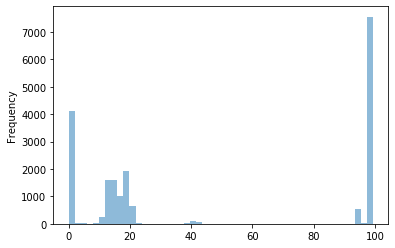

In [17]:
gpus['value'].plot.hist(bins=50, alpha=0.5)

We can now select GPU utilization values from different training phases (initialization, training loop and finalization) and get a histogram for those phases. The following cell retrieves the utilization values for initialization and we can then compare it with the histogram above:

In [18]:
gpus_training_loop = gpus[(gpus['timestamp'] < job_statistics['training_loop_start'])] 

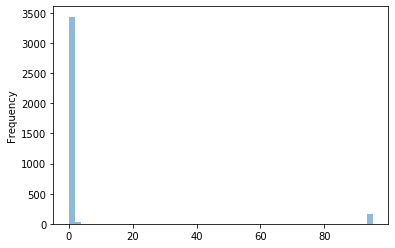

In [19]:
gpus_training_loop['value'].plot.hist(bins=50, alpha=0.5)

## 3.4 Low CPU utilization


Get all rows from Pandas frame which have CPU metrics.

In [20]:
cpus = system_metrics_df[system_metrics_df['system_metric'].str.match('cpu')]
cpus.head()

,timestamp,timestamp_us,value,system_metric
16,2020-08-06T07:12:36:124000,36124000,0.00,cpu8
17,2020-08-06T07:12:36:124000,36124000,2.00,cpu9
18,2020-08-06T07:12:36:124000,36124000,0.00,cpu10
19,2020-08-06T07:12:36:124000,36124000,96.15,cpu11
20,2020-08-06T07:12:36:124000,36124000,0.00,cpu22


Find all rows that have low CPU utilization:

In [21]:
print(len(cpus.loc[cpus['value'] == 0.0]), "datapoints out of", len(cpus), "where CPU utilization was at 0.")

13072 datapoints out of 78304 where CPU utilization was at 0.


In [22]:
print(len(cpus.loc[cpus['value'] < 50.0]), "datapoints out of", len(cpus), "where CPU utilization was below 50.")

19721 datapoints out of 78304 where CPU utilization was below 50.


Histogram of CPU utilization values. This plots shows the similar histogram like the one in the generic dashboards notebook:

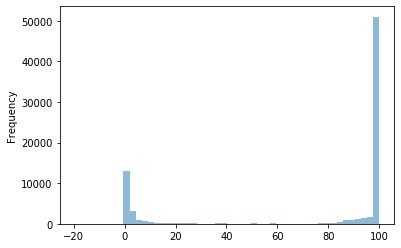

In [23]:
cpus['value'].plot.hist(bins=50, alpha=0.5)

We can now select CPU utilization values from different training phases (initialization, training loop and finalization) and get a histogram for those phases. The following cell retrieves the utilization values for initialization and we can then compare it with the histogram above:

In [24]:
cpus_initialization = cpus[cpus['timestamp'] < job_statistics['training_loop_start']]

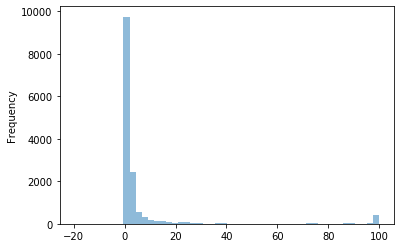

In [25]:
cpus_initialization['value'].plot.hist(bins=50, alpha=0.5)

## 3.5 Detect CPU bottlenecks
The time periods where GPU was at 0 percent but CPU was at a 100 percent may indicate a CPU bottleneck. This can for instance happen if data preprocessing is compute intensive and GPU is therefore waiting for new data batches to arrive. Let's retrieve the values when CPU was above 90% utilization and GPU below 10%:

In [26]:
high_cpu = cpus[cpus['value'] > 90.0]
low_gpu = gpus[gpus['value'] <= 10.0]


Next we merge both frames on the timestamp, which gives us the timestamps of the CPU bottlenecks:

In [27]:
cpu_bottleneck = low_gpu.merge(high_cpu, on='timestamp', how='inner')
cpu_bottleneck = cpu_bottleneck.drop_duplicates(subset=['system_metric_x','timestamp'], keep='first')
cpu_bottleneck.head()


,timestamp,timestamp_us_x,value_x,system_metric_x,timestamp_us_y,value_y,system_metric_y
0,2020-08-06T07:12:36:124000,36124000,0.0,gpu2,36124000,96.15,cpu11
2,2020-08-06T07:12:36:124000,36124000,0.0,gpu1,36124000,96.15,cpu11
3,2020-08-06T07:12:36:124000,36124000,0.0,gpu0,36124000,96.15,cpu11
6,2020-08-06T07:12:36:124000,36124000,0.0,gpu3,36124000,96.15,cpu11
8,2020-08-06T07:12:36:624000,36624000,0.0,gpu3,36624000,100.00,cpu11


In [ ]:
for timestamp in cpu_bottleneck['timestamp'].unique():
    print('CPU bottleneck observed at', timestamp)
    

Get CPU bottlenecks that happen during the training loop:

In [29]:
cpu_bottleneck_training_loop = cpu_bottleneck[cpu_bottleneck['timestamp'] > job_statistics['training_loop_start']]

In [66]:
cpu_bottleneck_training_loop.head()

,timestamp,timestamp_us_x,value_x,system_metric_x,timestamp_us_y,value_y,system_metric_y
2356,2020-08-06T07:16:21:706000,261706000,0.0,gpu1,261706000,100.0,cpu11
2358,2020-08-06T07:16:21:706000,261706000,0.0,gpu2,261706000,100.0,cpu11
2360,2020-08-06T07:16:21:706000,261706000,0.0,gpu3,261706000,100.0,cpu11
2362,2020-08-06T07:16:21:706000,261706000,0.0,gpu0,261706000,100.0,cpu11
2364,2020-08-06T07:16:22:207000,262207000,0.0,gpu2,262207000,98.0,cpu11


## 3.6 GPU usage during training loop 

Optimizing the performance of ML model training means to increase GPU usage. Let's create a Pie chart that shows the proportion between low and high GPU usage. We define the following intervals:
- GPU usage above 90%: optimal GPU usage
- GPU usage above 10% but below 90%: sub-optimal GPU usage
- GPU usage below 10% but CPU usage not at 100%: low GPU usage 
- CPU usage above 90% and GPU usage below 10%: low GPU usage likely due to CPU bottleneck

The Pie chart gives a rough estimate by how much we could possibly improve the training job performance.

In [30]:
system_usage = {'high_gpu_usage': len(gpus_training_loop[(gpus_training_loop['value'] > 90.0)]),
                'suboptimal_gpu_usage': len(gpus_training_loop[(gpus_training_loop['value'] < 90.0) & (gpus_training_loop['value'] > 10.0)]),
                'low_gpu_usage': len(gpus_training_loop[(gpus_training_loop['value'] <= 10.0)]) - len(cpu_bottleneck_training_loop),
                'cpu_bottleneck': len(cpu_bottleneck_training_loop)}


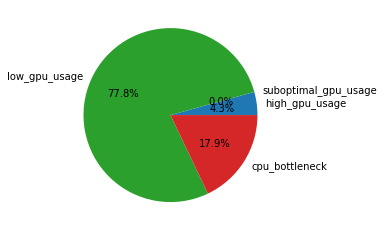

In [31]:
import matplotlib.pyplot as plt

plt.pie(system_usage.values(), autopct='%1.1f%%', labels=system_usage.keys(), labeldistance=1.3)
plt.show()

## 3.7 Detect workload balancing issues in multi-GPU training

If usage on one GPU is much higher compared to the remaining GPUs, then this indicates an isuee with how workload is distributed across multiple GPUs. We can determine such an issue in the generic dashboards notebook by looking at the histogram of usage values for different GPUs and check how much they differ. The following code cell will compute the histogram of usage values per GPU and measure the distance between the histograms.

In [32]:
n_gpus = len(gpus['system_metric'].unique())

Compute histogram of usage values per GPU:

In [33]:
import numpy as np

distributions = {}
for gpu in range(n_gpus):
    values = gpus[gpus['system_metric'] == 'gpu' + str(gpu)]['value']
    bins = np.arange(0, 100, 2)
    probs, binedges = np.histogram(values, bins=bins)
    distributions[gpu] = probs


Find which usage patterns exceed the threshold:

In [34]:
from scipy import stats

for gpu1 in range(n_gpus):
    for gpu2 in range(gpu1+1, n_gpus):
        m = (distributions[gpu1] + distributions[gpu2]) / 2
        divergence = (stats.entropy(distributions[gpu1], m) + stats.entropy(distributions[gpu2], m)) / 2
        distance = np.sqrt(divergence)
        
        if distance > 0.5:
            print('Workload between GPU', gpu1, 'and', gpu2, 'differs significantly. ')
        else:
            print('Workload between GPU', gpu1, 'and', gpu2, 'do not differ')

Workload between GPU 0 and 1 do not differ
Workload between GPU 0 and 2 do not differ
Workload between GPU 0 and 3 do not differ
Workload between GPU 1 and 2 do not differ
Workload between GPU 1 and 3 do not differ
Workload between GPU 2 and 3 do not differ


## 3.8 Detect outliers in step duration

We would expect that the average duration of training steps should be roughly the same. If there are significant outliers, it may indicate an issue. The following code cell computes the step duration and its median value.

In [35]:
train_steps = framework_metrics_df[framework_metrics_df['framework_metric'].isin(['Step:ModeKeys.TRAIN', 'Step:ModeKeys.GLOBAL'])]
step_durations = train_steps['end_time_us'] - train_steps['start_time_us']
median_train_steptime = step_durations.median()


Let's have a look on the training step durations:

In [36]:
step_durations.head()

0    58214803.0
1      105756.0
2       95643.0
3      132841.0
4       88546.0
dtype: float64

Median of training step durations:

In [37]:
median_train_steptime

110331.125

Next we select all training steps where duration was larger than twice the median:

In [38]:
outliers_train_steps = train_steps[step_durations > median_train_steptime * 2.0]
outliers_train_steps

,start_time,end_time,start_time_us,end_time_us,tid,pid,framework_metric,step,bytes,process,duration_us
0,2020-08-06T07:16:21:226054,2020-08-06T07:17:19:440857,2.612261e+08,3.194409e+08,8511450908796773373,80,Step:ModeKeys.TRAIN,0,-1,Step:ModeKeys.TRAIN,58214803.0
341,2020-08-06T07:17:57:535479,2020-08-06T07:17:58:616293,3.575355e+08,3.586163e+08,8511450908796773373,80,Step:ModeKeys.TRAIN,341,-1,Step:ModeKeys.TRAIN,1080814.0
783,2020-08-06T07:18:59:531811,2020-08-06T07:19:00:572037,4.195318e+08,4.205720e+08,8511450908796773373,80,Step:ModeKeys.TRAIN,782,-1,Step:ModeKeys.TRAIN,1040226.0
1566,2020-08-06T07:20:33:024124,2020-08-06T07:20:34:128437,5.130241e+08,5.141284e+08,8511450908796773373,80,Step:ModeKeys.TRAIN,1564,-1,Step:ModeKeys.TRAIN,1104313.0
2349,2020-08-06T07:22:08:153767,2020-08-06T07:22:09:141133,6.081538e+08,6.091411e+08,8511450908796773373,80,Step:ModeKeys.TRAIN,2346,-1,Step:ModeKeys.TRAIN,987366.0
3132,2020-08-06T07:23:43:605371,2020-08-06T07:23:44:687649,7.036054e+08,7.046876e+08,8511450908796773373,80,Step:ModeKeys.TRAIN,3128,-1,Step:ModeKeys.TRAIN,1082278.0
3916,2020-08-06T07:25:17:536311,2020-08-06T07:25:18:629557,7.975363e+08,7.986296e+08,8511450908796773373,80,Step:ModeKeys.TRAIN,3910,-1,Step:ModeKeys.TRAIN,1093246.0
4700,2020-08-06T07:26:51:496268,2020-08-06T07:26:52:563227,8.914963e+08,8.925632e+08,8511450908796773373,80,Step:ModeKeys.TRAIN,4692,-1,Step:ModeKeys.TRAIN,1066959.0
5483,2020-08-06T07:28:26:151493,2020-08-06T07:28:27:240156,9.861515e+08,9.872402e+08,8511450908796773373,80,Step:ModeKeys.TRAIN,5474,-1,Step:ModeKeys.TRAIN,1088663.0
6267,2020-08-06T07:30:00:618725,2020-08-06T07:30:01:740790,1.080619e+09,1.081741e+09,8511450908796773373,80,Step:ModeKeys.TRAIN,6256,-1,Step:ModeKeys.TRAIN,1122065.0


Let's consider all values below this threshold as normal step duration:

In [39]:
normal_train_steps = train_steps[step_durations < median_train_steptime * 2.0]

Free up some memory

In [40]:
del framework_metrics_df

## 3.9 Active dataloading threads/processes per seconds
In case of TF 2.2, profiler stores information about dataloding functions such as GetNext. The following analysis shows how many unique dataloading threads were active per time unit. If the number of threads is less than the available number of cores, we should increase the number of dataloading threads to increase performance. 

First we retrieve all rows that contain information about dataloading process:

In [ ]:
dataloaders = pf.get_all_framework_metrics(selected_framework_metrics=['Dataset', 'DataIterator'])

Set datateime index so that we can group by time:

In [42]:
import pandas as pd

if dataloaders.shape[0] > 0:
    dataloaders['start_time'] = pd.to_datetime(dataloaders['start_time'], format='%Y-%m-%dT%H:%M:%S:%f')
    dataloaders = dataloaders.set_index(['start_time'])
else:
    print('No profiling information for dataloaders available')

Count and plot the number of threads per seconds. A thread may be executed multiple times during a second so we possibly see a very high number.

In [43]:
if dataloaders.shape[0] > 0:
    active_threads_per_second = dataloaders['tid'].groupby([pd.Grouper(freq='1S')]).count()
else:
    print('No profiling information for dataloaders available')

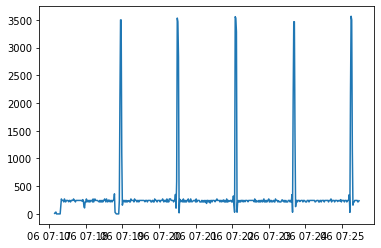

In [44]:
if dataloaders.shape[0] > 0:
    plt.plot(active_threads_per_second[:500])
else:
    print('No profiling information for dataloaders available')

Get the unique number of active threads per seconds. This tells us how many dataloaders were active each second:

In [45]:
if dataloaders.shape[0] > 0:
    unique_active_threads_per_second = dataloaders.groupby([pd.Grouper(freq='1S'), pd.Grouper('tid'), pd.Grouper('pid')]).agg(['count'])
else:
    print('No profiling information for dataloaders available')

Compare number of unique threads versus number of available cores:

In [46]:
cpus = system_metrics_df[system_metrics_df['system_metric'].str.match('cpu')]['system_metric'].unique()
n_cpus = len(cpus)

In [47]:
if dataloaders.shape[0] > 0:
    max_threads = unique_active_threads_per_second.groupby('start_time').count().max()[0]
    if max_threads < n_cpus:
        print("Available cores:", n_cpus, "Maximum number of threads seen per time aggregation", max_threads)
    
else:
    print('No profiling information for dataloaders available')

Available cores: 32 Maximum number of threads seen per time aggregation 21


# 4. Root cause analysis
Now that we retrieved some time periods where bottlenecks or outliers occur, it is time to correlate those timestamps with the framework metrics. This correlation can help to get an understanding what is causing a performance issue. We can compare the time spent in those metrics with the time spent when there is no bottleneck or outlier. The difference between both may give an indication what the possible root cause is. 

## 4.1. CPU bottlenecks

In this section, we will retrieve the framework metrics that were made at the time that a CPU bottleneck occured. 
For instance if the dataloading time significantly increases when GPU is at 0 and CPU is at 100 percent versus the dataloading time when GPU is at 100 percent then we can conclude that there is an issue in the data processing pipeline.


In [48]:
cpu_bottleneck.head()

,timestamp,timestamp_us_x,value_x,system_metric_x,timestamp_us_y,value_y,system_metric_y
0,2020-08-06T07:12:36:124000,36124000,0.0,gpu2,36124000,96.15,cpu11
2,2020-08-06T07:12:36:124000,36124000,0.0,gpu1,36124000,96.15,cpu11
3,2020-08-06T07:12:36:124000,36124000,0.0,gpu0,36124000,96.15,cpu11
6,2020-08-06T07:12:36:124000,36124000,0.0,gpu3,36124000,96.15,cpu11
8,2020-08-06T07:12:36:624000,36624000,0.0,gpu3,36624000,100.00,cpu11


Iterate over the timestamps when a CPU bottleneck occured and find framework metrics for these timesteps. We use the function `get_framework_metrics_by_timesteps` that takes a list of timestamps and returns3 dictionaries:

- **framework_metrics:** contains the cumulative time spent in an event_phase. A phase can contain multple functions. Cumulative time is normalized (divided the max value in the dictionary) so values are between 0-1
- **framework_metrics_detailed:** contains the cumulative time per function.
- **training_phase:** cumulative time spent in training and validation

In [ ]:
framework_metrics, framework_metrics_detailed, training_phase = pf.get_framework_metrics_by_timesteps(cpu_bottleneck['timestamp'].unique())

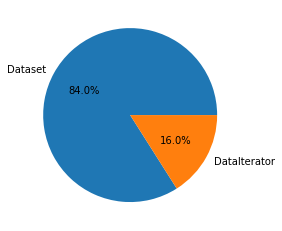

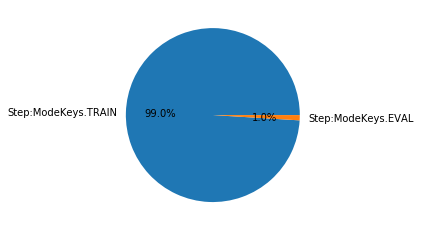

In [50]:
plt.pie(framework_metrics.values(), autopct='%1.1f%%', labels=framework_metrics.keys(), labeldistance=1.3)
plt.show()
plt.pie(training_phase.values(), autopct='%1.1f%%', labels=training_phase.keys(), labeldistance=1.3)
plt.show()

We have identified the functions that took most of the time when CPU bottlenecks occur. Let's those with the timestamps when there is not bottleneck happening:

In [51]:
high_gpu = gpus[gpus['value'] > 90.0]

In [ ]:
if high_gpu['timestamp'].shape[0] > 0:
    framework_metrics, framework_metrics_detailed, training_phase = pf.get_framework_metrics_by_timesteps(high_gpu['timestamp'].unique())

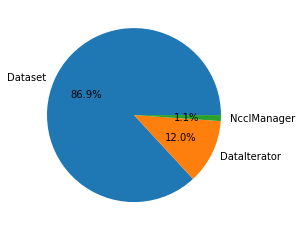

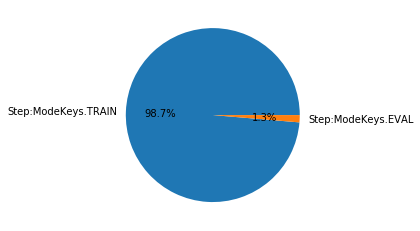

In [53]:
plt.pie(framework_metrics.values(), autopct='%1.1f%%', labels=framework_metrics.keys(), labeldistance=1.3)
plt.show()
plt.pie(training_phase.values(), autopct='%1.1f%%', labels=training_phase.keys(), labeldistance=1.3)
plt.show()

## 4.2 Outliers in step duration

Next we correlate the outliers in step duration with framework metrics. For instance how much time was spent in dataloading, preprocessing, synchronization when a step took singificantly more time. We then compare this to steps that have a normal duration to better understand whether there is a particular function that is causing a slowdown. 

First we call `get_framework_metrics_by_begin_and_end_timesteps`: this function takes list of timestamps and finds other framework metrics that were recorded in the given timeranges. The function will return two dictionaries that contain the normalized cumulative time per function.

In [ ]:
results = {}
results_detailed = {}
results['outlier'], results_detailed['outlier'] = pf.get_framework_metrics_by_begin_and_end_timesteps(
                                                                        outliers_train_steps['start_time'], 
                                                                        outliers_train_steps['end_time'])

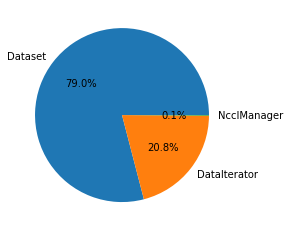

In [55]:
plt.pie(results['outlier'].values(), autopct='%1.1f%%', labels=results['outlier'].keys(), labeldistance=1.3)
plt.show()

Let's compare the relative time spent in those functions versus the relative time spent in those functions when train steps have a `normal` duration:

In [ ]:
results['normal'], results_detailed['normal'] = pf.get_framework_metrics_by_begin_and_end_timesteps(normal_train_steps['start_time'], 
                                                                        normal_train_steps['end_time'])

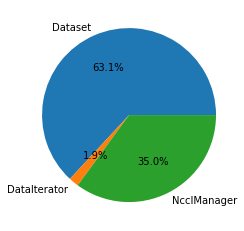

In [57]:
plt.pie(results['normal'].values(), autopct='%1.1f%%', labels=results['normal'].keys(), labeldistance=1.3)
plt.show()

Plot the results as bar chart to see a direct comparison. Here we plot the dictionary containing information per event/function:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f55b641b438>,
      dtype=object)

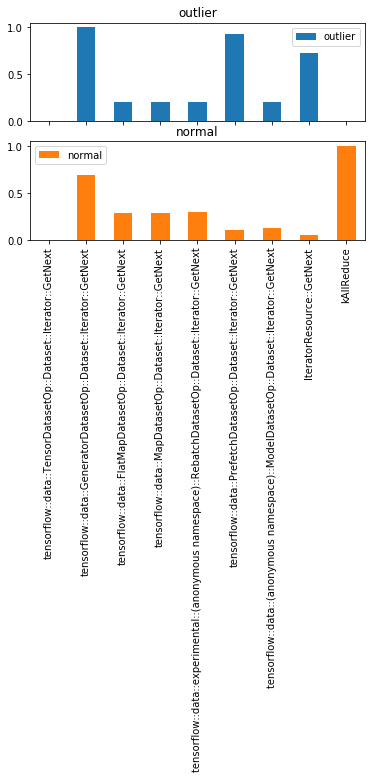

In [58]:
pd.DataFrame(results).plot(kind='bar', subplots=True) 

Get CPU/GPU utilization during train step outliers. If utilization is low, it may indicate a system stall. This can for instance happen if a process is waiting for an I/O request being resolved.

In [59]:
indexes = []
for start_time, end_time in zip(outliers_train_steps['start_time_us'].tolist(), 
                                outliers_train_steps['end_time_us'].tolist()):
    inds = system_metrics_df[(system_metrics_df['timestamp_us']  >= start_time) 
                        & (system_metrics_df['timestamp_us'] <= end_time)].index.tolist()
    if len(inds) > 0 :
        indexes.extend(inds)

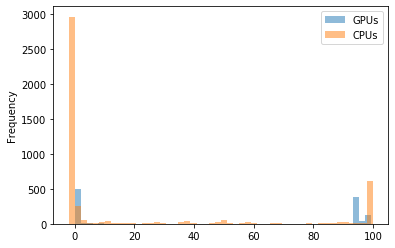

In [60]:
system_metrics_train_step_outliers = system_metrics_df.iloc[indexes,:]
gpus = system_metrics_train_step_outliers[system_metrics_train_step_outliers['system_metric'].str.match('gpu')]
cpus = system_metrics_train_step_outliers[system_metrics_train_step_outliers['system_metric'].str.match('cpu')]
gpus['value'].plot.hist(bins=50, alpha=0.5, legend=True, label="GPUs")
cpus['value'].plot.hist(bins=50, alpha=0.5, legend=True, label="CPUs")

For comparison CPU/GPU utilization during when training steps have normal duration:

In [61]:
indexes = []
for start_time, end_time in zip(normal_train_steps['start_time_us'].tolist(), 
                                normal_train_steps['end_time_us'].tolist()):
    inds = system_metrics_df[(system_metrics_df['timestamp_us']  >= start_time) 
                        & (system_metrics_df['timestamp_us'] <= end_time)].index.tolist()
    if len(inds) > 0 :
        indexes.extend(inds)

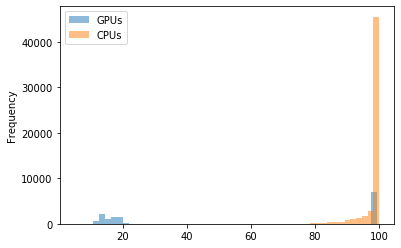

In [62]:
system_metrics_normal_train_step = system_metrics_df.iloc[indexes,:]
gpus = system_metrics_normal_train_step[system_metrics_normal_train_step['system_metric'].str.match('gpu')]
cpus = system_metrics_normal_train_step[system_metrics_normal_train_step['system_metric'].str.match('cpu')]
gpus['value'].plot.hist(bins=50, alpha=0.5, legend=True, label="GPUs")
cpus['value'].plot.hist(bins=50, alpha=0.5, legend=True, label="CPUs")

## 4.3 Idle time between training phases

The profiler captures events that occur during each training/validation step. It is of interest to observe activities or processes that occur in between two training steps or between training and validation steps, to detect unexpected resource utilization during these intervals.

For example, the trace event timeline below shows us a few training steps containing Dataset and DataIterator events. We observe a time interval between two TRAIN events where there is no event/no data about events. We would like to analyse any event that occurred during such intervals along with the corresponding system metrics to identify possible issues in the training process.

![timeline](images/timeline.png "Timeline")

In [63]:
util_stats = pf_analysis.get_utilization_stats(by=StatsBy.TRAINING_PHASE)

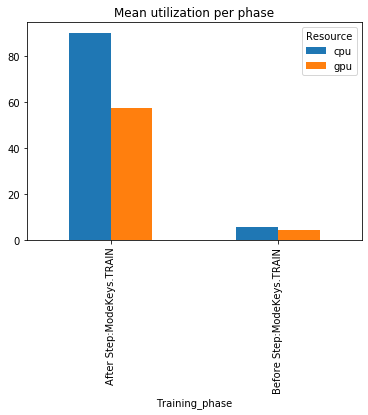

In [64]:
pivoted = util_stats.pivot(index='Training_phase', columns='Resource', values='utilization_mean_%').reset_index()
pivoted.plot.bar(x="Training_phase", y=["cpu", "gpu"], title="Mean utilization per phase")
 

As seen in the above plot, CPU/GPU utilization is observed in intervals other than when training is ongoing. Below, we will make use of Python profiling data to identify the cause for the observed resource utilization. In this case, we will look at Python profiling data between two arbitrary steps.

# 5 Python Profiling Data

Now we will look at Python stats collected for two sagemaker training jobs (Tensorflow and PyTorch) with Python profiling specifically enabled (via detailed profiling).

## 5.1 Load the Python Profiling Data
Here we have two training jobs that had Python profiling enabled. This means that for each job, we collect python stats for each phase in in the duration of steps specified in the config. 

In [1]:
import os
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.python_profile_analysis import PyinstrumentAnalysis
from smdebug.profiler.python_profiler import StepPhase
from IPython.display import IFrame

In [2]:
region = 'us-east-1'

In [3]:
tf_python_stats_dir = "tf_python_stats"
os.makedirs(tf_python_stats_dir, exist_ok=True)
tf_training_job_name = 'smprofiler-cpu-2020-08-08-01-48-19-643'
tf_tj = TrainingJob(tf_training_job_name, region)
tf_python_analysis = PyinstrumentAnalysis(local_profile_dir=tf_python_stats_dir, s3_path=tf_tj.profiler_s3_output_path)

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-072677473360/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DetailedProfilingConfig': '{"StartStep": 10 ,"NumSteps": 10}', 'ProfilerEnabled': 'True', 'UsePyinstrument': 'True'}}
s3 path:s3://sagemaker-us-east-1-072677473360/smprofiler-cpu-2020-08-08-01-48-19-643/profiler-output


In [19]:
pt_python_stats_dir = "pt_python_stats"
os.makedirs(pt_python_stats_dir, exist_ok=True)
pt_training_job_name = 'smprofiler-cpu-2020-08-18-22-00-29-170'
pt_tj = TrainingJob(pt_training_job_name, region)
pt_python_analysis = PyinstrumentAnalysis(local_profile_dir=pt_python_stats_dir, s3_path=pt_tj.profiler_s3_output_path)

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-072677473360/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DetailedProfilingConfig': '{"StartStep": 10, "NumSteps": 10}', 'ProfilerEnabled': 'True', 'UsePyinstrument': 'True'}}
s3 path:s3://sagemaker-us-east-1-072677473360/smprofiler-cpu-2020-08-18-22-00-29-170/profiler-output


## 5.2 Analyze general Python profiling data.
This will give us insight into the metadata regarding each instance of Python profiling as well as bottlenecks that we can easily identify by visualizing the call stack.

Let's take a look at what Python profiling data was collected. Each `step_stats` refers to a specific instance of Python profiling, which has its associated stats files. In this case, since we used pyinstrument as our profiler, there are two types (JSON and HTML) of stats files for each instance of profiling. The first two rows (with start step -1) refer to the stats collected during pre-step 0 profiling, which includes user code in the training script.

In [7]:
tf_stats = list(map(lambda x: vars(x), tf_python_analysis.list_profile_stats()))
tf_step_stats_df = pd.DataFrame(tf_stats)
tf_step_stats_df.head()

,profiler_name,framework,start_time_since_epoch_in_micros,end_time_since_epoch_in_micros,node_id,start_phase,start_step,end_phase,end_step,stats_path
0,pyinstrument,tensorflow,1.596852e+15,1.596852e+15,77-algo-1,StepPhase.START,-1,StepPhase.STEP_START,0,tf_python_stats/python_stats/tensorflow_159685...
1,pyinstrument,tensorflow,1.596852e+15,1.596852e+15,77-algo-1,StepPhase.START,-1,StepPhase.STEP_START,0,tf_python_stats/python_stats/tensorflow_159685...
2,pyinstrument,tensorflow,1.596852e+15,1.596852e+15,77-algo-1,StepPhase.STEP_START,10,StepPhase.STEP_END,10,tf_python_stats/python_stats/tensorflow_159685...
3,pyinstrument,tensorflow,1.596852e+15,1.596852e+15,77-algo-1,StepPhase.STEP_START,10,StepPhase.STEP_END,10,tf_python_stats/python_stats/tensorflow_159685...
4,pyinstrument,tensorflow,1.596852e+15,1.596852e+15,77-algo-1,StepPhase.STEP_END,10,StepPhase.STEP_START,11,tf_python_stats/python_stats/tensorflow_159685...


In [20]:
pt_stats = list(map(lambda x: vars(x), pt_python_analysis.list_profile_stats()))
pt_step_stats_df = pd.DataFrame(pt_stats)
pt_step_stats_df.head()

,profiler_name,framework,start_time_since_epoch_in_micros,end_time_since_epoch_in_micros,node_id,start_phase,start_step,end_phase,end_step,stats_path
0,pyinstrument,pytorch,1.597788e+15,1.597788e+15,71-algo-1,StepPhase.START,-1,StepPhase.STEP_START,0,pt_python_stats/python_stats/pytorch_159778833...
1,pyinstrument,pytorch,1.597788e+15,1.597788e+15,71-algo-1,StepPhase.START,-1,StepPhase.STEP_START,0,pt_python_stats/python_stats/pytorch_159778833...
2,pyinstrument,pytorch,1.597788e+15,1.597788e+15,71-algo-1,StepPhase.STEP_START,10,StepPhase.FORWARD_PASS_END,10,pt_python_stats/python_stats/pytorch_159778836...
3,pyinstrument,pytorch,1.597788e+15,1.597788e+15,71-algo-1,StepPhase.STEP_START,10,StepPhase.FORWARD_PASS_END,10,pt_python_stats/python_stats/pytorch_159778836...
4,pyinstrument,pytorch,1.597788e+15,1.597788e+15,71-algo-1,StepPhase.FORWARD_PASS_END,10,StepPhase.STEP_START,11,pt_python_stats/python_stats/pytorch_159778836...


First, let's take a look at the pre-step 0 profiling stats. Can we spot any bottlenecks in the user's training code for each job? Try looking at how long it takes for the data to be downloaded or loaded.

*If you get a 404 error running the following cells, try rerunning them (sometimes running the cells too quickly will trigger the 404).*

In [21]:
tf_pyinstrument_pre_step_zero_stats = tf_python_analysis.fetch_pre_step_zero_profile_stats()
IFrame(src=tf_pyinstrument_pre_step_zero_stats[0].html_file_path, width= 1000, height=500)

In [22]:
pt_pyinstrument_pre_step_zero_stats = pt_python_analysis.fetch_pre_step_zero_profile_stats()
IFrame(src=pt_pyinstrument_pre_step_zero_stats[0].html_file_path, width= 1000, height=500)

Now, let's look at the profiling stats between two arbitrary steps that we profiled for these jobs. Can we spot the bottlenecks here? You should be looking for a function called `between_steps_bottleneck`.

*If you get a 404 error running the following cells, try rerunning them (sometimes running the cells too quickly will trigger the 404).*

In [23]:
profiler_config = eval(tf_tj.profiler_config["ProfilingParameters"]["DetailedProfilingConfig"])
start_step = profiler_config["StartStep"]
end_step = start_step + 1
start_phase = StepPhase.STEP_END
end_phase = StepPhase.STEP_START 

tf_pyinstrument_stats = tf_python_analysis.fetch_profile_stats_by_step(start_step, end_step, start_phase, end_phase)
IFrame(src=tf_pyinstrument_stats[0].html_file_path, width= 1000, height=300)

In [24]:
profiler_config = eval(pt_tj.profiler_config["ProfilingParameters"]["DetailedProfilingConfig"])
start_step = profiler_config["StartStep"]
end_step = start_step + 1
start_phase = StepPhase.FORWARD_PASS_END
end_phase = StepPhase.STEP_START 

pt_pyinstrument_stats = pt_python_analysis.fetch_profile_stats_by_step(start_step, end_step, start_phase, end_phase)
IFrame(src=pt_pyinstrument_stats[0].html_file_path, width= 1000, height=300)